In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2 as cv
import os
from tqdm import tqdm
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
root_path = r'/kaggle/input/animal-classification/Data/'
class_names = sorted(os.listdir(root_path))
print(class_names)

['Buffalo', 'Elephant', 'Rhino', 'Zebra']


In [4]:
import pywt

def pi_wavelet_transform(root_path, class_names, img_size):
    labels_encoded = []
    transformed_data = []

    for name in class_names:
        folderpath = os.path.join(root_path, name)
        for image_name in tqdm(os.listdir(folderpath)):
            # Load the image in grayscale
            img = cv.imread(os.path.join(folderpath, image_name),cv.IMREAD_GRAYSCALE)
            # Resize the image to the desired size
            img = cv.resize(img, (img_size, img_size))

            # Apply the pi wavelet transform
            coeffs2 = pywt.dwt2(img, 'haar')
            LL, (LH, HL, HH) = coeffs2
            LL = np.expand_dims(LL, axis=2)
            LH = np.expand_dims(LH, axis=2)
            HL = np.expand_dims(HL, axis=2)
            HH = np.expand_dims(HH, axis=2)

            # Concatenate the wavelet coefficients
            features = np.concatenate([LL, LH, HL, HH], axis=2)
            transformed_data.append(features)
            labels_encoded.append(class_names.index(name))

        X_wave = np.array(transformed_data) / 255.0
        y_wave = np.array(labels_encoded)


    return X_wave, y_wave

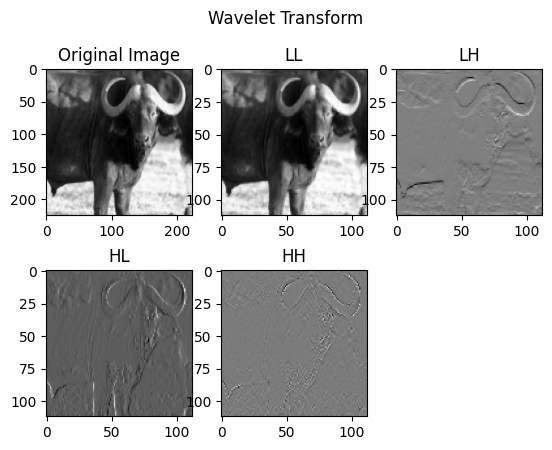

In [7]:
import matplotlib.pyplot as plt

def visualize_wavelet_transform(original_img, transformed_coeffs, title):
    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')

    # Display the LL sub-band
    plt.subplot(2, 3, 2)
    plt.imshow(transformed_coeffs[0], cmap='gray')
    plt.title('LL')

    # Display the LH sub-band
    plt.subplot(2, 3, 3)
    plt.imshow(transformed_coeffs[1], cmap='gray')
    plt.title('LH')

    # Display the HL sub-band
    plt.subplot(2, 3, 4)
    plt.imshow(transformed_coeffs[2], cmap='gray')
    plt.title('HL')

    # Display the HH sub-band
    plt.subplot(2, 3, 5)
    plt.imshow(transformed_coeffs[3], cmap='gray')
    plt.title('HH')

    plt.suptitle(title)
    plt.show()

# Example usage:
# Assuming img is the original image and coeffs2 is the wavelet coefficients
img = cv.imread('/kaggle/input/animal-classification/Data/Buffalo/Buffalo_7.jpg', cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (224, 224))
coeffs2 = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs2

# Visualize the transformation
visualize_wavelet_transform(img, [LL, LH, HL, HH], 'Wavelet Transform')

In [6]:
img_size = 224
X_wave, y_wave = pi_wavelet_transform(root_path, class_names, img_size)
X_train_wave, X_test_wave, y_train_wave, y_test_wave = train_test_split(X_wave, y_wave, test_size=0.1, random_state=101)

100%|██████████| 1000/1000 [00:07<00:00, 132.80it/s]


In [8]:
X_train_wave.shape

(3600, 112, 112, 4)

In [14]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
model = Sequential([
    Flatten(input_shape=(112,112,4)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

In [16]:
# Compile the model with 'sparse_categorical_crossentropy'
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_wave, y_train_wave, epochs=30, validation_data=(X_test_wave, y_test_wave))

Epoch 1/30
113/113 [==============================] - 3s 14ms/step - loss: 1.4992 - accuracy: 0.3686 - val_loss: 1.4246 - val_accuracy: 0.3575
Epoch 2/30
113/113 [==============================] - 1s 7ms/step - loss: 1.3510 - accuracy: 0.3719 - val_loss: 1.3494 - val_accuracy: 0.4175
Epoch 3/30
113/113 [==============================] - 1s 7ms/step - loss: 1.3480 - accuracy: 0.3611 - val_loss: 1.3270 - val_accuracy: 0.4625
Epoch 4/30
113/113 [==============================] - 1s 8ms/step - loss: 1.2973 - accuracy: 0.3747 - val_loss: 1.3502 - val_accuracy: 0.3825
Epoch 5/30
113/113 [==============================] - 1s 7ms/step - loss: 1.3632 - accuracy: 0.3194 - val_loss: 1.3287 - val_accuracy: 0.4400
Epoch 6/30
113/113 [==============================] - 1s 7ms/step - loss: 1.2958 - accuracy: 0.3825 - val_loss: 1.3527 - val_accuracy: 0.3375
Epoch 7/30
113/113 [==============================] - 1s 7ms/step - loss: 1.2935 - accuracy: 0.3792 - val_loss: 1.3356 - val_accuracy: 0.3425
Epoch

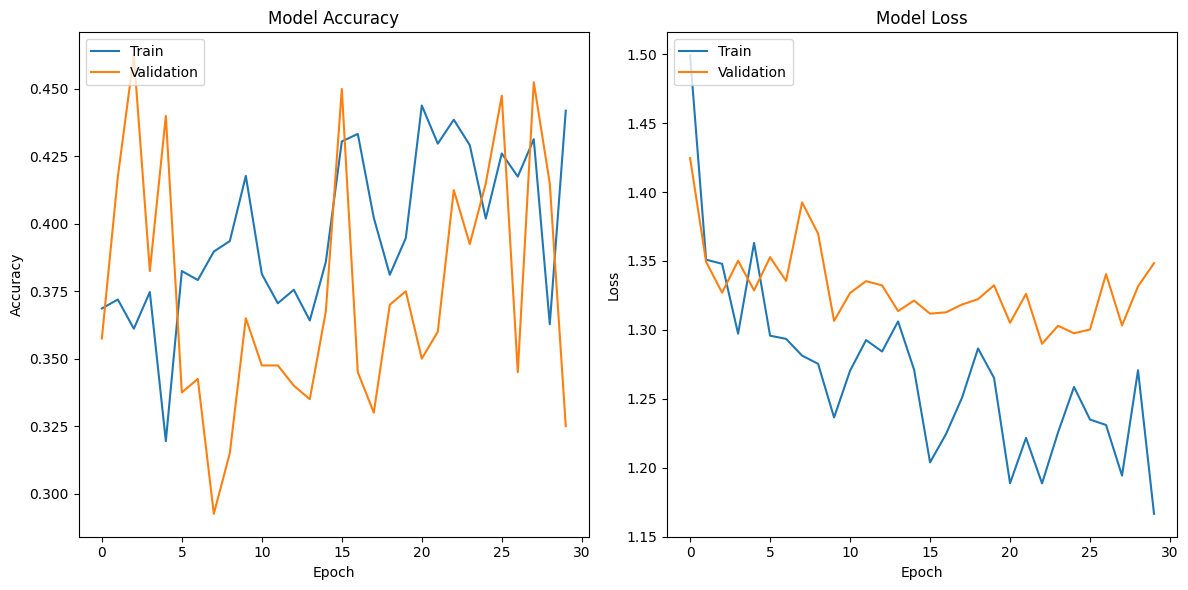

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
model.save("featureextractio_Wavelet.h5")
model.save("featureextractio_Wavelet.keras")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
